In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Load the weather data and merge them into our two DataFrames.'''
path = r'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather\data'
os.chdir(path)
print('Loading weather events')
weather_events = pd.read_csv('weather_events.csv')
print('Loading flight data')
departing_flights = pd.read_csv('departing_flights.csv')
arriving_flights = pd.read_csv('arriving_flights.csv')

Loading weather events
Loading flight data


In [3]:
# Merge the DataFrames.
departure_events = departing_flights.merge(
    weather_events, how='left', left_on=['ORIGIN','DepartureDate'],
    right_on=['Airport','Date'], validate='one_to_many')
arrival_events = arriving_flights.merge(
    weather_events, how='left', left_on=['DEST','ArrivalDate'],
    right_on=['Airport','Date'], validate='one_to_many')

In [4]:
# Drop redundant columns.
departure_events.drop(['Airport','Date'], axis=1, inplace=True)
arrival_events.drop(['Airport','Date'], axis=1, inplace=True)

# Clean up the column names.
inputVars = pd.Series(['Cold','Fog','Hail','Rain','Snow','Storm'], name='Code')
column_renames = {'ARR_DEL15':'ArrivDel',
                  'DEP_DEL15':'DepartDel',
                  'ColdCode':'Cold',
                  'FogCode':'Fog',
                  'HailCode':'Hail',
                  'RainCode':'Rain',
                  'SnowCode':'Snow',
                  'StormCode':'Storm'}
departure_events.rename(columns=column_renames, inplace=True)
arrival_events.rename(columns=column_renames, inplace=True)

# NaN's mean no weather events on that day. Fill them in with 0's.
for column in inputVars:
    departure_events[column].fillna(0, inplace=True)
    arrival_events[column].fillna(0, inplace=True)

In [5]:
# Save the results.
# departure_events.to_csv('departure_events.csv') #Uncomment to save.
# arrival_events.to_csv('arrival_events.csv')

In [6]:
'''Exploratory data analysis'''
FRAC_CANCELLED = 'FracCancelled'
FRAC_DELAYED = 'FracDelayed'
departure_events[FRAC_CANCELLED] = departure_events.WeatherCancelled/departure_events.Flights
arrival_events[FRAC_CANCELLED] = arrival_events.WeatherCancelled/arrival_events.Flights
departure_events[FRAC_DELAYED] = departure_events.WeatherDelayed/departure_events.Flights
arrival_events[FRAC_DELAYED] = arrival_events.WeatherDelayed/arrival_events.Flights

X_dep = departure_events.loc[:, inputVars].to_numpy()
X_arr = arrival_events.loc[:, inputVars].to_numpy()

In [7]:
#Get the correlation matrix of data with X's features as columns.
def corrMatrixAndMax(X, labels=inputVars):
    corr = np.corrcoef(X, rowvar=False)
    n = corr.shape[0]
    max_corr_ID = np.argmax(np.abs(corr) - np.eye(n))
    return corr, np.unravel_index(max_corr_ID, [n,n])

#Get the most correlated elements off the main diagonal and their names and coordinates'''
def getCorrNameCoords(CorrMatrix, coordinates, labels=inputVars):
    coordinates = tuple(coordinates)
    return round(CorrMatrix[tuple(coordinates)], 3),\
        list(labels.iloc[list(coordinates)].values), coordinates
        
#Max absolute difference.'''
def maxAbsDiff(A, B, axis=None):
    return np.max(np.abs(A-B), axis=axis)

In [8]:
print('Deviation from X_dep and array of ints:', maxAbsDiff(X_dep, X_dep.astype(int)) )
print('Deviation from X_arr and array of ints:', maxAbsDiff(X_arr, X_arr.astype(int)) )
X_dep = X_dep.astype(int)
X_arr = X_arr.astype(int)

print('Calculating correlation matrices')
Corr_X_dep, coords_max_Corr_X_dep = corrMatrixAndMax(X_dep)
Corr_X_arr, coords_max_Corr_X_arr = corrMatrixAndMax(X_arr)
print('Max abs difference between Corr_X_dep and Corr_X_arr:', maxAbsDiff(Corr_X_dep, Corr_X_arr))
#Nearly identical, which makes sense given that they're from the same dates and airports.

Deviation from X_dep and array of ints: 0.0
Deviation from X_arr and array of ints: 0.0
Calculating correlation matrices
Max abs difference between Corr_X_dep and Corr_X_arr: 0.0005175599595751285


In [9]:
EV_CORR_MTRX = ' event correlation matrix:\n'
CORR_NAME_COORDS = 'Createst correlation and name and coordinates:'
print('\nDeparture' + EV_CORR_MTRX, Corr_X_dep)
print(CORR_NAME_COORDS, getCorrNameCoords(Corr_X_dep, coords_max_Corr_X_dep))
print('\nArrival event correlation matrix:\n', Corr_X_arr)
print(CORR_NAME_COORDS, getCorrNameCoords(Corr_X_arr, coords_max_Corr_X_arr))


Departure event correlation matrix:
 [[ 1.          0.01839478 -0.00279033  0.008945    0.05171379  0.03977564]
 [ 0.01839478  1.          0.01398625  0.11192157  0.14234472  0.01266164]
 [-0.00279033  0.01398625  1.          0.08252664  0.21847251 -0.0053578 ]
 [ 0.008945    0.11192157  0.08252664  1.          0.01543107  0.10957254]
 [ 0.05171379  0.14234472  0.21847251  0.01543107  1.          0.03476355]
 [ 0.03977564  0.01266164 -0.0053578   0.10957254  0.03476355  1.        ]]
Createst correlation and name and coordinates: (0.218, ['Hail', 'Snow'], (2, 4))

Arrival event correlation matrix:
 [[ 1.          0.01843476 -0.00278268  0.00901806  0.05173312  0.03978591]
 [ 0.01843476  1.          0.01404223  0.11243913  0.14248089  0.01274211]
 [-0.00278268  0.01404223  1.          0.08258726  0.2184916  -0.00534308]
 [ 0.00901806  0.11243913  0.08258726  1.          0.01572157  0.10966187]
 [ 0.05173312  0.14248089  0.2184916   0.01572157  1.          0.03480327]
 [ 0.03978591  0.01

This is suspicious. Hail is a warm-weather event; snow is a cold-weather event. Perhaps
sleet is being called "hail" in some cases. 'Cold' and 'Snow' only has a correlation of
0.052, but recall that 'Cold' was originally called "Severe Cold," probably meaning
temperatures well below freezing. For example, this weather event:

    https://www.weather.gov/lot/RecordColdJan2019
    
got a "cold" code for Chicago. It caused over 500 departure weather cancellations
at O'Hare per day!

Overall the correlations seem fairly low, but both correlation matrices include
all the rows of 0, where there are no weather events. We need to reevaluate
based on the rows that are not all zero.

In [10]:
nonzero_X_dep = X_dep[np.where(X_dep.any(axis=1))[0]]
nonzero_X_arr = X_arr[np.where(X_arr.any(axis=1))[0]]
print('Max abs difference between nonzero_X_dep and nonzero_X_arr:',
      maxAbsDiff(nonzero_X_dep, nonzero_X_arr)) #Same matrices!
nonzero_Corr_X_dep, nonzero_coords_max_Corr_X_dep = corrMatrixAndMax(nonzero_X_dep)

Max abs difference between nonzero_X_dep and nonzero_X_arr: 0


Now the greatest correlation is between rain and fog, at about -0.297. Paradoxically,
this correlation was positive with all zero rows included! Perhaps the arbitrary numbering
of the intensities significantly affects the correlations. However, the hail-snow
correlation is nearly unchanged. 

Because the untrimmed departure and arrival correlation matrices are nearly identical,
we will just use the departure events now. Let's see what the average values per
column are, weighted by flight.

In [11]:
'''Now let's do some plots, per code, categorized by code value. To make things
simpler we will not weight these values for now.'''
for feature in range(X_dep.shape[1]):
    print('Feature ' + str(feature) + ':', end=' ')
    for unique_value in np.unique(X_dep[:,feature]):
        print(unique_value, end=' ')
    print()

Feature 0: 0 1 
Feature 1: 0 1 2 
Feature 2: 0 1 
Feature 3: 0 1 2 3 
Feature 4: 0 1 2 3 
Feature 5: 0 1 


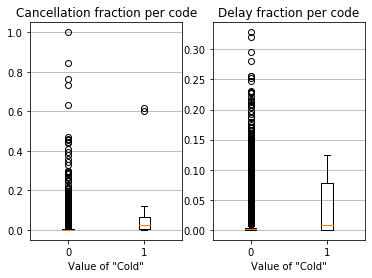

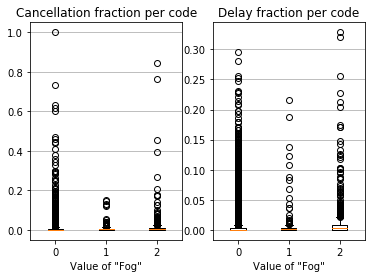

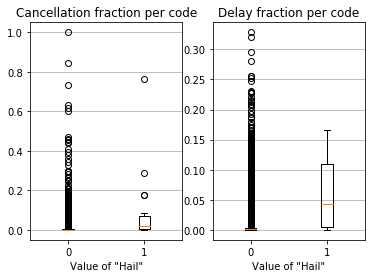

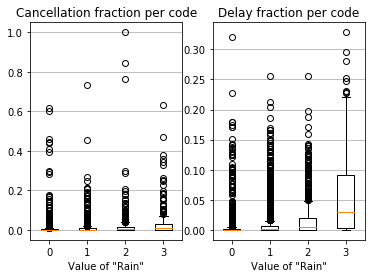

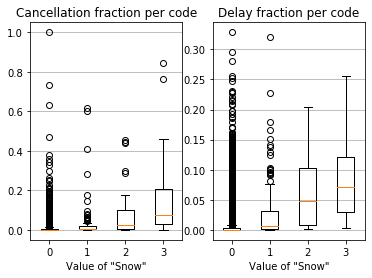

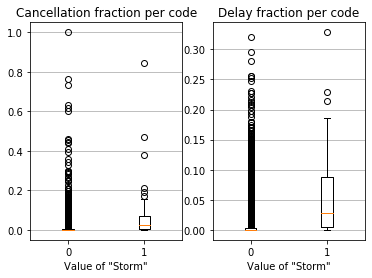

In [12]:
frac_cancelled = departure_events['FracCancelled'].to_numpy()
frac_delayed = departure_events['FracDelayed'].to_numpy()

for i, code in enumerate(inputVars):
    unique_codes = np.unique(X_dep[:,i])
    indices_per_value = [np.where(X_dep[:,i]==j)[0] for j in unique_codes]
    cancelled_per_code = [frac_cancelled[indices_per_value[j]] for j in unique_codes]
    delayed_per_code = [frac_delayed[indices_per_value[j]] for j in unique_codes]
    
    fig, axs = plt.subplots(1,2)
    axs[0].boxplot(cancelled_per_code)
    axs[0].set_title('Cancellation fraction per code')
    axs[1].boxplot(delayed_per_code)
    axs[1].set_title('Delay fraction per code')
    for j in [0,1]:
        axs[j].set_xticklabels(unique_codes)
        axs[j].set_xlabel('Value of "' + code + '"')
        axs[j].yaxis.grid(True)
    plt.show()

The medians of some of these features clearly are affected by the feature value;
however, none of them seem to add up to much more than about 0.20, meaning that
we should not expect that these weather events will have an overwhelming affect
on delays and cancellations. Still, there do seem to be trends that emerge.